# Pneumonia Detection Using Convolutional Neural Network

In [170]:
import tensorflow as tf

print("Available devices:")
print(tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available; using CPU instead.")


Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available.


In [171]:
tf.debugging.set_log_device_placement(True)

## Exploratory Data Analysis

### Data Download & Extraction

In [172]:
import os
import zipfile

In [174]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


#### NORMAL

In [175]:
import numpy as np
import pandas as pd
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from PIL import Image
import cv2
import seaborn as sns

In [176]:
import warnings
warnings.filterwarnings('ignore')

#### Image Size

In [177]:
Image.open('/home/agaonkar/private/chest_xray/train/NORMAL/IM-0115-0001.jpeg').size

(2090, 1858)

In [178]:
Image.open('/home/agaonkar/private/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg').size

(712, 439)

#### Image Shape/Number of Channels

In [179]:
img = cv2.imread('/home/agaonkar/private/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
print(img.shape)

(439, 712, 3)


In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

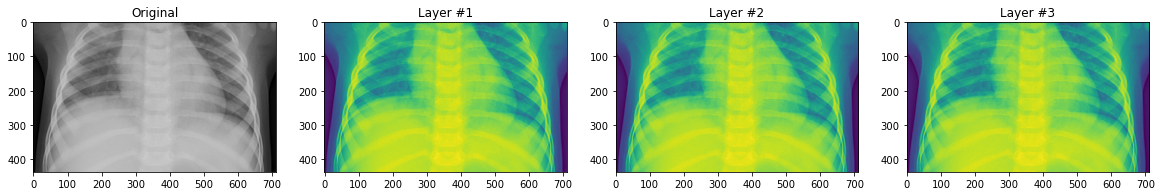

In [181]:
# DISPLAYING ORIGINAL & EACH LAYER SEPARATELY
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
axes[0].imshow(img)
axes[0].set_title('Original')

for i in range(1,4):
    ax = axes[i]
    ax.imshow(img[:, :, (i-1)])
    ax.set_title(f'Layer #{i}')

plt.savefig('/home/agaonkar/private/img_breakdown.png', bbox_inches='tight', dpi=300);

At first look, these 3 layers appear to be identical, but we can also reconfirm by comparing the pixel values of the 3 layers:

In [182]:
print((img[:, :, 0] == img[:, :, 1]).all())
print((img[:, :, 0] == img[:, :, 2]).all())

True
True


### DataFrames

In [183]:
import glob
from pathlib import Path

In [184]:
# GET THE DIRECTORY TO THE DATASETS
path_data = '/home/agaonkar/private/chest_xray'
path_train = os.path.join(path_data, 'train')
path_test = os.path.join(path_data, 'test')

# INITIATE EMPTY LIST OF TRAINING DATA
# THAT WILL BE CONVERTED TO PANDAS DATAFRAME LATER
data_train = []
data_test = []
data = [data_train, data_test]

# ITERATE THROUGH EACH PATH
for i, d in enumerate([path_train, path_test]):
    # GET THE PATH TO EACH FOLDER - NORMAL AND PNEUMONIA
    normal = os.path.join(d, 'NORMAL')
    pneumonia = os.path.join(d, 'PNEUMONIA')

    # FETCH ALL .jpeg FILES
    normal_imgs = Path(normal).glob('*.jpeg')
    pneumonia_imgs = Path(pneumonia).glob('*.jpeg')

    # APPEND THE NAME AND CORRESPONDING LABEL (BASED ON FOLDER NAME)
    # TO data_train list AS TUPLES
    for img in normal_imgs:
        data[i].append((str(img), 0))

    for img in pneumonia_imgs:
        data[i].append((str(img), 1))

In [185]:
# CONVERT data_train TO DATAFRAME FOR EASY MANIPULATION
columns = ['image', 'label']

train_df = pd.DataFrame(data_train, columns=columns)
test_df = pd.DataFrame(data_test, columns=columns)

In [186]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5216 non-null   object
 1   label   5216 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.6+ KB


In [187]:
train_df.label.value_counts(normalize=True)

label
1    0.742906
0    0.257094
Name: proportion, dtype: float64

In [188]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   624 non-null    object
 1   label   624 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.9+ KB


In [189]:
test_df.label.value_counts(normalize=True)

label
1    0.625
0    0.375
Name: proportion, dtype: float64

In [190]:
# CONCAT train_df and val_df
master_df = pd.concat([train_df, test_df])
# RESET INDEX (SO THERE WON'T BE ANY DUPLICATED INDICES) BY DROPPING OLD ONES
master_df.reset_index(inplace=True, drop=True)

In [191]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5840 non-null   object
 1   label   5840 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.4+ KB


In [192]:
# CHECK FOR DUPLICATES
master_df.duplicated().any()

False

In [193]:
# FETCH 10 RANDOM SAMPLES FROM master_df
master_df.sample(10, random_state=42)

,image,label
4582,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
177,/home/agaonkar/private/chest_xray/train/NORMAL...,0
167,/home/agaonkar/private/chest_xray/train/NORMAL...,0
3722,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
2339,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
1047,/home/agaonkar/private/chest_xray/train/NORMAL...,0
4676,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
3955,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
2534,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
1501,/home/agaonkar/private/chest_xray/train/PNEUMO...,1


In [194]:
4265 + 1575

5840

In [195]:
master_df.label.value_counts()

label
1    4265
0    1575
Name: count, dtype: int64

In [196]:
master_df.label.value_counts(normalize=True)

label
1    0.730308
0    0.269692
Name: proportion, dtype: float64

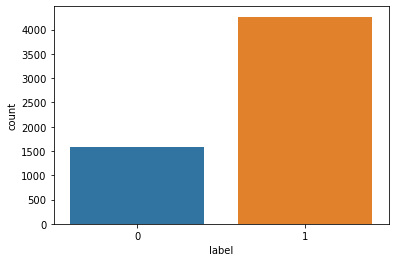

In [197]:
sns.countplot(x='label', data=master_df)
plt.savefig('/home/agaonkar/private/class_ratio.png', bbox_inches='tight', dpi=300);

In [198]:
def cat_pneumonia_type(x):
    if 'BACTERIA' in x:
        output = 'bacteria'
    elif 'VIRUS' in x:
        output = 'virus'
    else:
        output = 'normal'
    return output

In [199]:
master_df['type'] = master_df.image.apply(lambda x: cat_pneumonia_type(x))

In [200]:
master_df.type.value_counts()

type
normal    5840
Name: count, dtype: int64

### Dataset Splitting

In [202]:
from sklearn.model_selection import train_test_split

In [203]:
# TRAIN TEST SPLIT (TEST SIZE = 15%)
master_train_df, test_df = train_test_split(master_df, test_size=0.15, random_state=42)

In [204]:
# TRAIN VALIDATION SPLIT (VALIDATION SIZE = 20%)
train_df, val_df = train_test_split(master_train_df, test_size=0.2, random_state=42)

In [205]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3971 entries, 234 to 1512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3971 non-null   object
 1   label   3971 non-null   int64 
 2   type    3971 non-null   object
dtypes: int64(1), object(2)
memory usage: 124.1+ KB


In [206]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 993 entries, 5768 to 2661
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   993 non-null    object
 1   label   993 non-null    int64 
 2   type    993 non-null    object
dtypes: int64(1), object(2)
memory usage: 31.0+ KB


In [207]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 4582 to 2850
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   876 non-null    object
 1   label   876 non-null    int64 
 2   type    876 non-null    object
dtypes: int64(1), object(2)
memory usage: 27.4+ KB


### Data Generators

In [208]:
BATCH_SIZE = 32

# CREATE GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='grayscale',   # only keeping 1 channel of the images
    class_mode='raw',
    target_size=(180,180),   # resizing all images to 180 x 180 pixel
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True   # shuffle so we're not missing out on any samples
)

# CREATE GENERATOR FOR VALIDATION DATA (FROM val_df DATAFRAME)
val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    color_mode='grayscale',
    class_mode='raw',
    target_size=(180,180),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True
)

Found 3971 validated image filenames.
Found 993 validated image filenames.


In [209]:
# CHECKING THE SHAPE OF 1 BATCH OF THE train_generator
images_train, labels_train = next(train_generator)
print(f'Training set: {images_train.shape} | {labels_train.shape}')

Training set: (32, 180, 180, 1) | (32,)


### Data Visualization

Next, I am going to display the first 16 images of the first batch with their corresponding labels:

- 0 - NORMAL
- 1 - PNEUMONIA

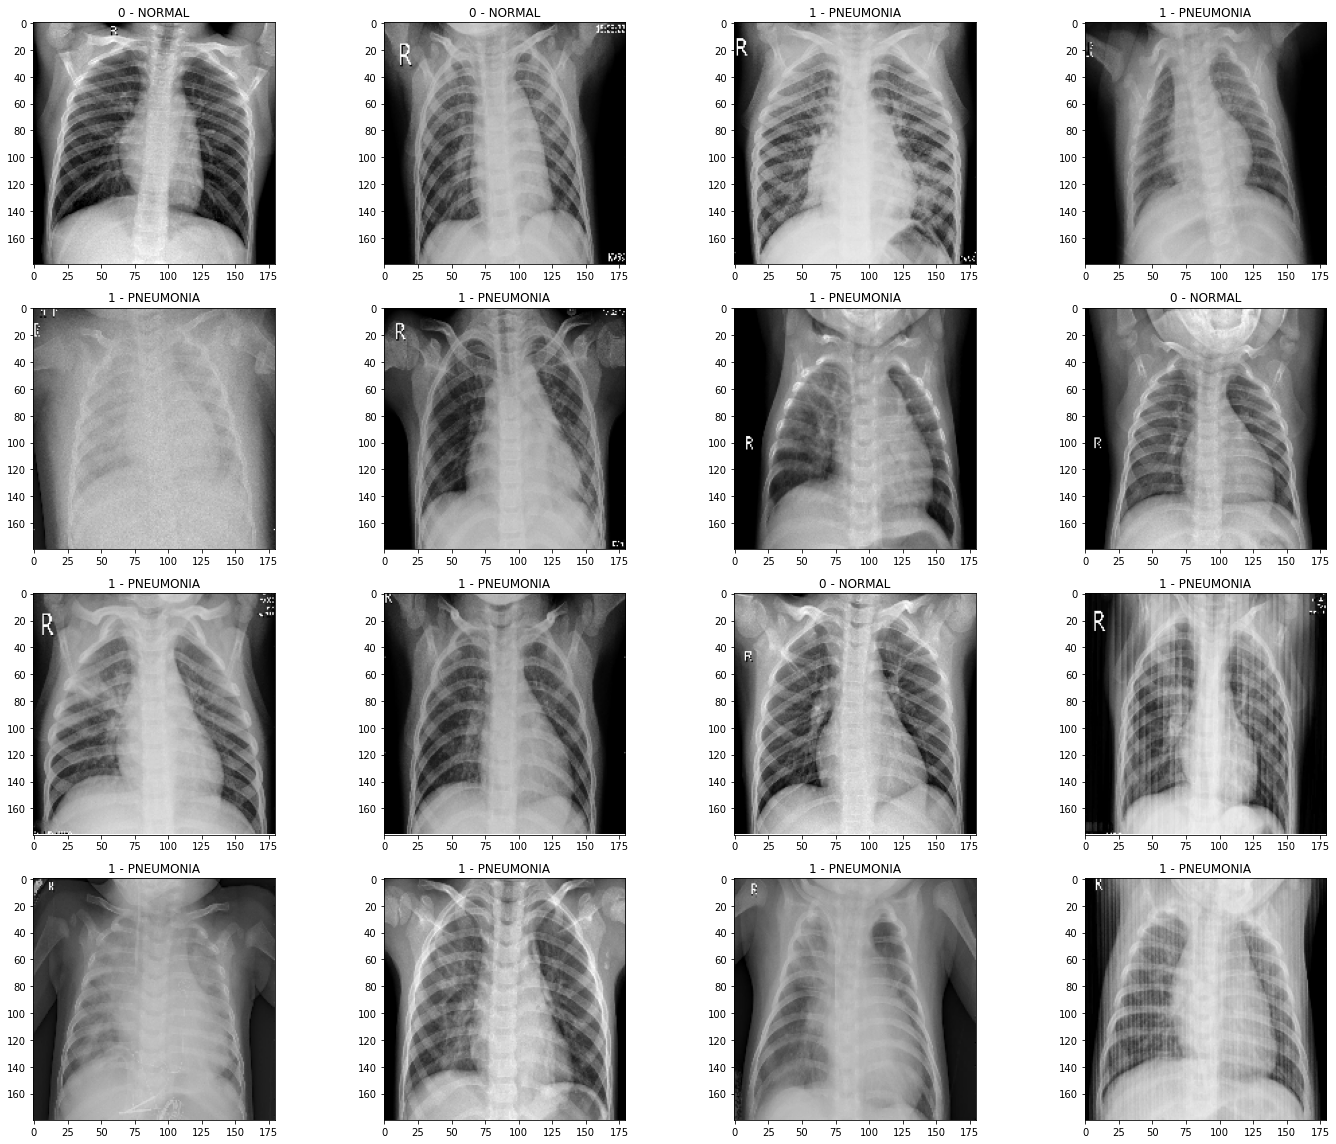

In [210]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,16))
label_output = {0: 'NORMAL', 1: 'PNEUMONIA'}
i = range(16)

for i in range(16):
    ax = axes[i // 4][i % 4]
    ax.imshow(images_train[i], cmap='gray')
    ax.set_title(f'{labels_train[i]} - {label_output[labels_train[i]]}')

plt.tight_layout()
plt.savefig('/home/agaonkar/private/samples_16.png', bbox_inches='tight', dpi=300);
plt.show();

### Model #1 - CNN from Scratch

Next, I am going to construct another Convolutional Neural Networks (CNN) model with a few more Convolutional & MaxPooling layers to see if they migh help increase model performance further:
- 1 Layer of Convolution 2D with padding
- 1 Layer of MaxPooling 2D
- 1 Layer of Convolution 2D with padding
- 1 Layer of MaxPooling 2D
- 1 Hidden Layer of Dense NN

(This architecture have been selected arbitrarily for the most part, and will be adjusted later depending on the outcome).

In [214]:
from keras.metrics import Recall, Precision
cnn_2 = Sequential()
cnn_2.add(Conv2D(32, (3,3), activation='relu', padding='same',
               input_shape=[180,180,1]))
cnn_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
cnn_2.add(MaxPooling2D(pool_size=(2,2)))
cnn_2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
cnn_2.add(MaxPooling2D(pool_size=(2,2)))
cnn_2.add(Flatten())
cnn_2.add(Dense(32, activation='relu'))
cnn_2.add(Dense(1, activation='sigmoid'))

In [220]:
recall = Recall()
precision = Precision()

In [221]:
cnn_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', recall, precision])

cnn_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      320       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 259200)           

In [222]:
checkpoint_cb = ModelCheckpoint('cnn_2.h5',
                                save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True)

BATCH_SIZE = 32
EPOCHS = 30

results_2 = cnn_2.fit(train_generator, 
                      validation_data=val_generator,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_generator.n//BATCH_SIZE),
                      validation_steps=(val_generator.n//BATCH_SIZE),
                      callbacks=[checkpoint_cb, early_stopping_cb],
                      use_multiprocessing=True,
                      workers=8)

Epoch 1/30
124/124 [==============================] - 20s 124ms/step - loss: 0.3841 - accuracy: 0.8352 - recall_1: 0.9199 - precision_1: 0.8631 - val_loss: 0.2005 - val_accuracy: 0.9224 - val_recall_1: 0.9417 - val_precision_1: 0.9534
Epoch 2/30
124/124 [==============================] - 15s 113ms/step - loss: 0.1680 - accuracy: 0.9342 - recall_1: 0.9596 - precision_1: 0.9506 - val_loss: 0.1714 - val_accuracy: 0.9355 - val_recall_1: 0.9240 - val_precision_1: 0.9884
Epoch 3/30
124/124 [==============================] - 15s 116ms/step - loss: 0.1311 - accuracy: 0.9507 - recall_1: 0.9676 - precision_1: 0.9649 - val_loss: 0.1288 - val_accuracy: 0.9466 - val_recall_1: 0.9512 - val_precision_1: 0.9764
Epoch 4/30
124/124 [==============================] - 15s 116ms/step - loss: 0.1140 - accuracy: 0.9566 - recall_1: 0.9690 - precision_1: 0.9714 - val_loss: 0.1265 - val_accuracy: 0.9516 - val_recall_1: 0.9607 - val_precision_1: 0.9739
Epoch 5/30
124/124 [==============================] - 15s 11

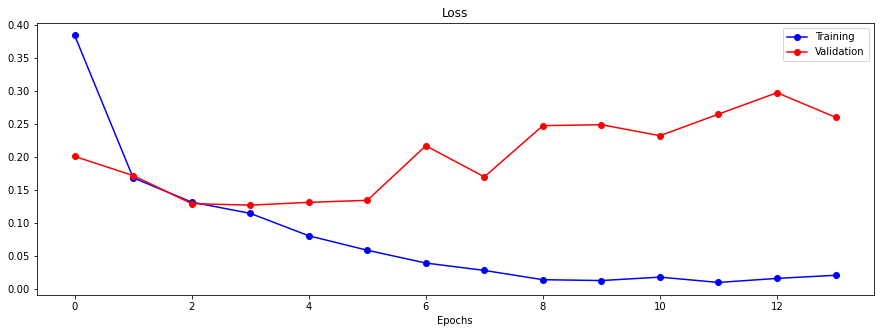

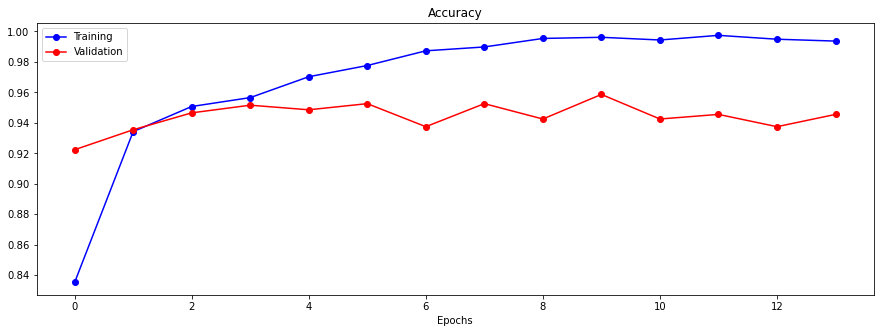

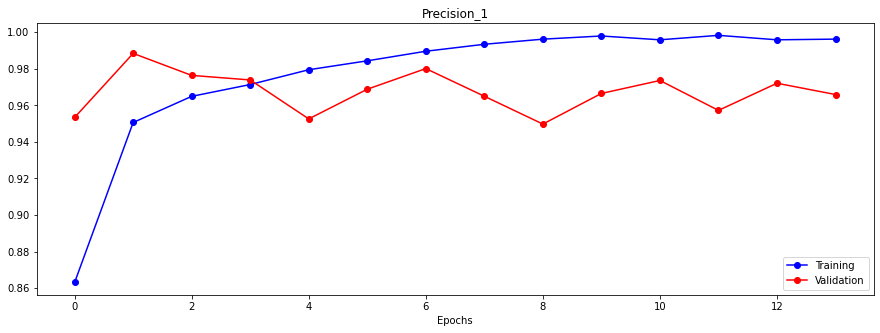

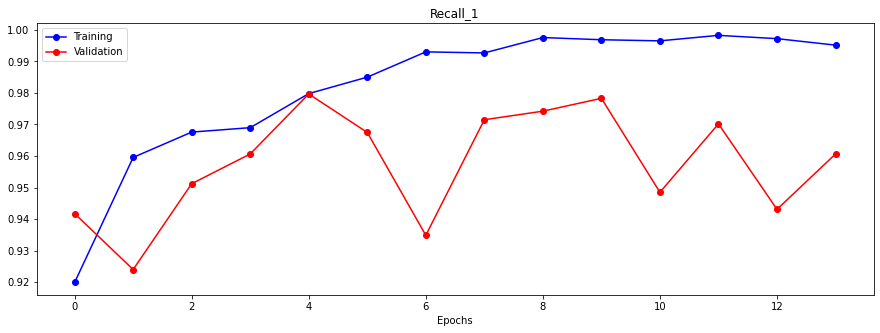

In [224]:
# VISUALIZE MODEL PERFORMANCE
def visualize_training_results(results):
    history = results.history
    
    for m in ['loss', 'accuracy', 'precision_1', 'recall_1']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show();
visualize_training_results(results_2)

In [226]:
# MAKE PREDICTIONS USING THE EVALUATION GENERATORS
preds_train_2 = cnn_2.predict(train_generator, 
                                steps=(train_generator.n//BATCH_SIZE+1), 
                                verbose=1,
                                workers=8)
preds_val_2 = cnn_2.predict(val_generator, 
                              steps=(val_generator.n//BATCH_SIZE+1),
                              verbose=1,
                              workers=8)

32/32 [==============================] - 2s 36ms/step


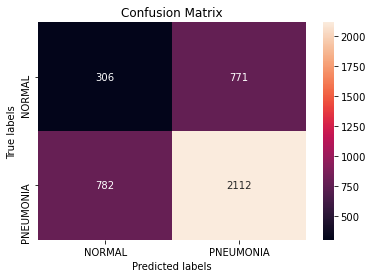

In [227]:
# PLOT CONFUSION MATRIX FOR TRAINING SET
# (converting predicted values from float to nearest integer)
plot_confusionmatrix(train_df['label'], np.rint(preds_train_2))  

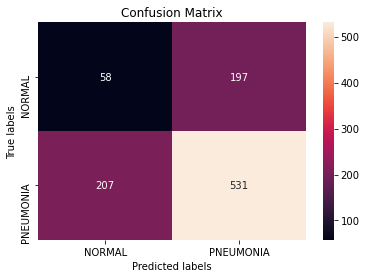

In [228]:
# PLOT CONFUSION MATRIX FOR VALIDATION SET
plot_confusionmatrix(val_df['label'], np.rint(preds_val_2))

In [229]:
cnn_2_metrics = cnn_2.evaluate(val_eval_generator)

32/32 [==============================] - 7s 224ms/step - loss: 0.1264 - accuracy: 0.9517 - recall_1: 0.9607 - precision_1: 0.9739


In [230]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
def plot_confusionmatrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    ax= plt.subplot()
    # annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    plt.show();

In [231]:
# SAVE THE MODEL
cnn_2.save("cnn_2.h5")

In [240]:
BATCH_SIZE = 32

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=test_df, x_col='image', y_col='label',
    class_mode='raw',
    color_mode='grayscale',
    target_size=(180,180), batch_size=BATCH_SIZE,
    seed=2021,
    shuffle=False
)

Found 876 validated image filenames.


In [241]:
preds_test_2 = cnn_2.predict(test_generator,
                            steps=(test_generator.n//BATCH_SIZE+1),
                            verbose=1,
                            workers=8)

28/28 [==============================] - 1s 39ms/step


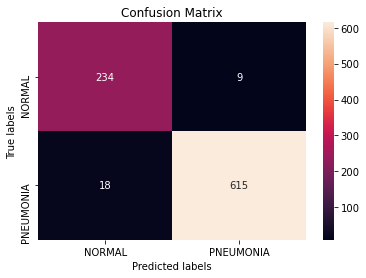

In [242]:
plot_confusionmatrix(test_df['label'], np.rint(preds_test_2)) 

In [243]:
cnn_2.evaluate(test_generator)

28/28 [==============================] - 6s 223ms/step - loss: 0.1081 - accuracy: 0.9692 - recall_1: 0.9716 - precision_1: 0.9856


[0.10806829482316971,
 0.9691780805587769,
 0.971563994884491,
 0.9855769276618958]

In [244]:
# CALCULATE cnn_4's PERFORMANCE METRICS ON VALIDATION SET
cnn_2_metrics = cnn_2.evaluate(test_generator)
# CREATE A DATAFRAME TO KEEP TRACK OF ALL MODELS PERFOMANCE ON VALIDATION SET
perf_df = pd.DataFrame(columns=['model', 'loss', 'accuracy', 'recall', 'precision'])
perf_df.loc[len(perf_df.index)] = ['CNN'] + cnn_2_metrics
perf_df

28/28 [==============================] - 6s 227ms/step - loss: 0.1081 - accuracy: 0.9692 - recall_1: 0.9716 - precision_1: 0.9856


,model,loss,accuracy,recall,precision
0,CNN,0.108068,0.969178,0.971564,0.985577


In [237]:
from sklearn.metrics import confusion_matrix
from math import sqrt

# Compute confusion matrix
cm = confusion_matrix(test_df['label'], np.rint(preds_test_3))
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = TP / (TP + 0.5 * (FP + FN))

# Matthews correlation coefficient (MCC)
mcc_numerator = TN * TP - FN * FP
mcc_denominator = sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
mcc_score = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

# Cohen's Kappa score
kappa_numerator = 2 * (TP * TN - FN * FP)
kappa_denominator = (TP + FP) * (FP + TN) + (TP + FN) * (FN + TN)
kappa_score = kappa_numerator / kappa_denominator if kappa_denominator != 0 else 0

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"MCC Score: {mcc_score:.4f}")
print(f"Kappa Score: {kappa_score:.4f}")


Accuracy: 0.9623
Precision: 0.9688
Recall: 0.9795
F1 Score: 0.9741
MCC Score: 0.9054
Kappa Score: 0.9052
